In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../') 

from cosmosis.model import FFNet
from cosmosis.learning import Learn, Selector
from cosmosis.dataset import SKDS

from dataset import QM7, QM7b, QM7X, QM9, ANI1x

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

RDKit WARNING: [18:50:08] Enabling RDKit 2019.09.3 jupyter extensions


CDataset created...
SKDS make_regression created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:03.720834
epoch: 0, lr: 0.01
train loss: 28734.545789930555, val loss: 21179.165234375
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:09.906006
epoch: 10, lr: 0.005
train loss: 544.8085609718605, val loss: 527.746044921875
sklearn train metric: 0, sklearn validation metric: 0
test loss: 511.7072387695313
learning time: 0:00:15.787556
sklearn test metric: 
0 



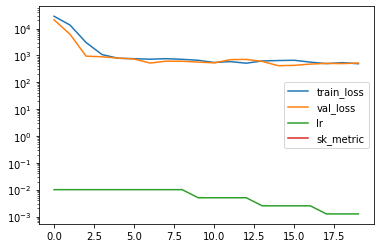

In [2]:
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['X'],
                              'targets': ['y'],
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'make': 'make_regression',
                              'transform': [],
                              'target_transform': [],
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 128}}}

metrics_params = {'report_interval': 10}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([SKDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False,
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.967757
epoch: 0, lr: 0.01
train loss: 1531.5182527240954, val loss: 1502.23291015625
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:09.281182
epoch: 10, lr: 0.01
train loss: 35.08216406169691, val loss: 31.662063598632812
sklearn train metric: 0, sklearn validation metric: 0
test loss: 32.130637645721436
learning time: 0:00:17.023184
sklearn test metric: 
0 



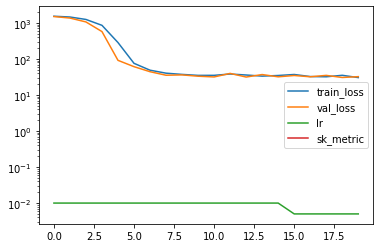

In [3]:
model_params = {'D_in': 23*23+23*32, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atoms',7,32,None,True)]}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['ae'],
                              'embeds': ['atoms'],
                              'in_file': './data/qm7/qm7.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:00.613372
epoch: 0, lr: 0.01
train loss: 1562.351382606908, val loss: 1545.6412658691406
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:06.774388
epoch: 10, lr: 0.01
train loss: 56.577617846037214, val loss: 60.67550277709961
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:12.879684
epoch: 20, lr: 0.01
train loss: 46.75776973523592, val loss: 57.241790771484375
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:18.888067
epoch: 30, lr: 0.005
train loss: 42.00589852584036, val loss: 51.2036657333374
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:24.950807
epoch: 40, lr: 0.005
train loss: 40.30644848472193, val loss: 53.352646827697754
sklearn train metric: 0, sklearn validation metric: 0
test loss: 54.21363162994385
learning time: 0:00:30.699092
sklearn test metric: 
0 



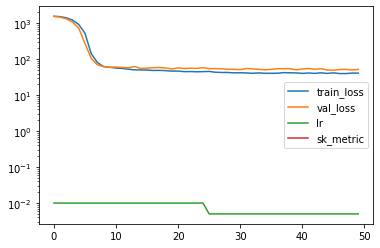

In [4]:
model_params = {'D_in': 23*23, 
                'H': 2048, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'features': ['coulomb'],
                              'targets': ['E'],
                              'in_file': './data/qm7b/qm7b.mat',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

In [6]:
#find the longest molecule

ds_params = {'train_params': {'features': ['atNUM'],
                              'pad': None,
                              'targets': [],
                              'embeds': [],
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])
l = 0
for i in qm7x.ds_idx:
    s = qm7x[i][0].shape[0]
    if s > l:
        l = s
print('longest molecule length: ', l)

qm7x[1]

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
CDataset created...
longest molecule length:  23


(array([6., 1., 1., 1., 1.], dtype=float32), [], [])

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  6950
total molecular structures (idconf) mapped:  41537
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:01.773108
epoch: 0, lr: 0.01
train loss: 66.4335056104158, val loss: 45.5223388671875
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:12.989721
epoch: 7, lr: 0.01
train loss: 2.6686283789182963, val loss: 2.5566316843032837
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:17.866593
epoch: 10, lr: 0.01
train loss: 2.1241006662971094, val loss: 2.0431875586509705
sklearn train metric: 0, sklearn validation metric: 0
l

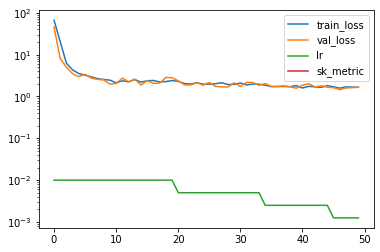

In [8]:
model_params = {'D_in': 23*23+23*64, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atNUM',9,64,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'pad': 23,
                              'targets': ['eAT'],
                              'embeds': ['atNUM'],
                              'selector': ['opt'],
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=50)

loading QM9 datadic from a pickled copy...
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:04.153304
epoch: 0, lr: 0.01
train loss: 337.3235367995042, val loss: 289.6648315429687
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:12.444180
epoch: 10, lr: 0.01
train loss: 8.606407660704393, val loss: 8.63420934677124
sklearn train metric: 0, sklearn validation metric: 0
test loss: 7.723360347747803
learning time: 0:00:20.142390
sklearn test metric: 
0 



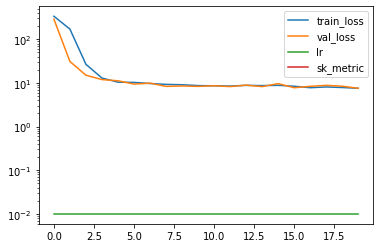

In [3]:
model_params = {'D_in': 29*29, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {#'n': 10000, 
                              'features': ['coulomb'],
                              'embeds': [], 
                              'targets': ['U0'],
                              'pad': 29, 
                              'filter_on': None,
                              'use_pickle': 'qm9.p',
                              'flatten': True}}

metrics_params = {'report_interval': 10}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=20)

creating QM9 dataset...
QM9 molecules scanned:  1
QM9 molecules created:  0
QM9 molecules scanned:  10001
QM9 molecules created:  1853
QM9 molecules scanned:  20001
QM9 molecules created:  4109
QM9 molecules scanned:  30001
QM9 molecules created:  5164
QM9 molecules scanned:  40001
QM9 molecules created:  8487
QM9 molecules scanned:  50001
QM9 molecules created:  10694
QM9 molecules scanned:  60001
QM9 molecules created:  15309
QM9 molecules scanned:  70001
QM9 molecules created:  20609
QM9 molecules scanned:  80001
QM9 molecules created:  25898
QM9 molecules scanned:  90001
QM9 molecules created:  32036
QM9 molecules scanned:  100001
QM9 molecules created:  38581
QM9 molecules scanned:  110001
QM9 molecules created:  46307
QM9 molecules scanned:  120001
QM9 molecules created:  54330
QM9 molecules scanned:  130001
QM9 molecules created:  58020
total uncharacterized molecules removed:  467
total QM9 molecules created:  57590
pickling a copy of the QM9 datadic...
CDataset created...
CMod

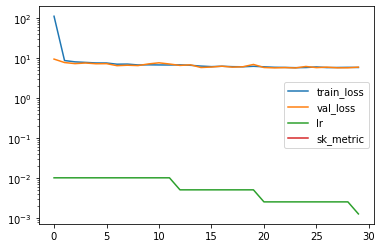

In [4]:
model_params = {'D_in': 29*29, 
                'H': 4096, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': []}

ds_params = {'train_params': {#'n': 10000,
                              'features': ['coulomb'],
                              'embeds': [],
                              'targets': ['U0'],
                              'pad': 29, 
                              'filter_on': ('n_atoms','>','18'),
                              'use_pickle': 'n_atoms_greater_than_18.p',
                              'flatten': True}}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 2}
opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=256, epochs=30)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
CModel loaded...
FFNet model loaded...
learning time: 0:00:02.820987
epoch: 0, lr: 0.01
train loss: 564.5048971737133, val loss: 530.1419677734375
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:13.677173
epoch: 5, lr: 0.01
train loss: 43.002085966222424, val loss: 51.827823638916016
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:24.495524
epoch: 10, lr: 0.01
train loss: 35.56331432566923, val loss: 31.64513333638509
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:35.258592
epoch: 15, lr: 0.005
train loss: 29.48338934954475, val loss: 32.54748280843099
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:46.045871
epoch: 20, lr: 0.005
train loss: 28.11592618156882, val loss: 35.997650146484375
sklearn train metric: 0, sklearn validation metric: 0
learning time: 0:00:56.9051

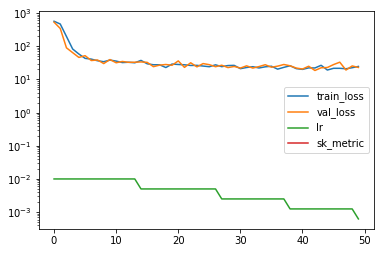

In [5]:
model_params = {'D_in': 63*63+63*32, 
                'H': 8192, 
                'D_out': 1, 
                'model_name': 'funnel',
                'embed_params': [('atomic_numbers',9,32,None,True)]}

ds_params = {'train_params': {'features': ['distance'],
                              'targets': ['wb97x_dz.energy'],
                              'embeds': ['atomic_numbers'],
                              'pad': 63, #length of the longest molecule in the dataset
                              'flatten': True,
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'random',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          adapt=False, load_model=False, load_embed=False, save_model=False, 
          batch_size=128, epochs=50)